# **한국어 문장 분류 경진 대회**

- 추가 데이터 : KLUE Official Dev Data 
[http://klue-benchmark.com/tasks/68/data/download](https://)

In [ ]:
from google import colab
colab.drive.mount("/content/drive")

Mounted at /content/drive


# **1. 모듈 설치 및 import**

In [ ]:
!pip install transformers datasets
!pip install selenium
!apt-get update
!apt install chromium-chromedriver
!pip install googletrans==4.0.0-rc1        

In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd

import os
import random
from tqdm import tqdm

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold, train_test_split

import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from transformers import AutoTokenizer, TFAutoModel, AdamWeightDecay, AutoModelForSequenceClassification, AutoConfig, AutoTokenizer, TrainingArguments, Trainer
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.callbacks import EarlyStopping

import selenium
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import time
import googletrans
from googletrans import Translator

/usr/local/lib/python3.7/dist-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.8) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


In [ ]:
def seed_everything(seed: int = 2022):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    tf.random.set_seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)  # type: ignore
    torch.backends.cudnn.deterministic = True  # type: ignore
    torch.backends.cudnn.benchmark = True  # type: ignore

seed_everything()

# **2. DATA LOAD**

## 2-1 기존 데이터, DEV 추가 데이터 : `train_total` for model1

In [ ]:
train_path = "/content/drive/MyDrive/Colab Notebooks/nli/data/train_data.csv"
test_path = "/content/drive/MyDrive/Colab Notebooks/nli/data/test_data.csv"
sub_path = "/content/drive/MyDrive/Colab Notebooks/nli/data/sample_submission.csv"
data_path = "/content/drive/MyDrive/Colab Notebooks/nli/data/translate/"

train_path2 = "/content/drive/MyDrive/Colab Notebooks/nli/klue-nli-v1.1/klue-nli-v1.1_dev.json"

In [ ]:
sub_path = "/content/drive/MyDrive/Colab Notebooks/nli/data/sample_submission.csv"
submission = pd.read_csv(sub_path)

In [ ]:
train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)
train_additional = pd.read_json(train_path2)

In [ ]:
train_additional = train_additional[['premise','hypothesis','gold_label']]
train_additional.columns = ['premise','hypothesis','label']

In [ ]:
train_total = pd.concat([train_df,train_additional])
train_total.drop('index', axis = 1,inplace = True)

## 2-2 번역데이터 준비

In [ ]:
def chrome_setting():
  chrome_options = webdriver.ChromeOptions()
  chrome_options.add_argument('--headless')
  chrome_options.add_argument('--no-sandbox')
  chrome_options.add_argument('--disable-dev-shm-usage')
  driver = webdriver.Chrome('chromedriver', options=chrome_options)
  return driver

In [ ]:
driver=chrome_setting()

### Premise KOR > ENG (using PAPAGO, Googletrans)
- papago 크롤링은 뉴스 토픽 분류 AI 경진대회 최종 3th Kerry님의 코드를 참고했습니다 🙇

In [ ]:
#파파고 크롤링
def kor_to_trans(text_data, trans_lang,start_index,final_index):

  target_present = EC.presence_of_element_located((By.XPATH, '//*[@id="txtTarget"]'))

  for i in tqdm(range(start_index,final_index)): 
    
    if (i!=0)&(i%99==0):
      driver.implicitly_wait(2)
      print('{}th : '.format(i), backtrans)
      np.save(data_path+'p_kor_to_eng_train_{}_{}.npy'.format(start_index,final_index),trans_list)
    
    try:
      driver.get('https://papago.naver.com/?sk=ko&tk='+trans_lang+'&st='+text_data[i])
      time.sleep(1.5)
      element=WebDriverWait(driver, 10).until(target_present)
      time.sleep(0.1)
      backtrans = element.text 

      if (backtrans=='')|(backtrans==' '):
        element=WebDriverWait(driver, 10).until(target_present)
        backtrans = element.text 
        trans_list.append(backtrans)
      else:
        trans_list.append(backtrans)
    
    except:
      trans_list.append('')

In [ ]:
trans_list=[]
kor_to_trans(train_df['premise'], 'en',0,2500)
np.save(data_path+'p_kor_to_eng_train_0_2500.npy',trans_list)

trans_list=[]
kor_to_trans(train_df['premise'], 'en',2500,5000)
np.save(data_path+'p_kor_to_eng_train_2500_5000.npy',trans_list)

trans_list=[]
kor_to_trans(train_df['premise'], 'en',5000,7500)
np.save(data_path+'p_kor_to_eng_train_5000_7500.npy',trans_list)

trans_list=[]
kor_to_trans(train_df['premise'], 'en',7500,10000)
np.save(data_path+'p_kor_to_eng_train_7500_10000.npy',trans_list)

trans_list=[]
kor_to_trans(train_df['premise'], 'en',10000,12500)
np.save(data_path+'p_kor_to_eng_train_10000_12500.npy',trans_list)

trans_list=[]
kor_to_trans(train_df['premise'], 'en',12500,15000)
np.save(data_path+'p_kor_to_eng_train_12500_15000.npy',trans_list)

trans_list=[]
kor_to_trans(train_df['premise'], 'en',15000,17500)
np.save(data_path+'p_kor_to_eng_train_15000_17500.npy',trans_list)

trans_list=[]
kor_to_trans(train_df['premise'], 'en',17500,20000)
np.save(data_path+'p_kor_to_eng_train_17500_20000.npy',trans_list)

trans_list=[]
kor_to_trans(train_df['premise'], 'en',20000,22500)
np.save(data_path+'p_kor_to_eng_train_20000_22500.npy',trans_list)

trans_list=[]
kor_to_trans(train_df['premise'], 'en',22500,len(train))
np.save(data_path+'p_kor_to_eng_train_22500_all.npy',trans_list) #24998개 번역

In [ ]:
eng_data0 = np.load(data_path+'p_kor_to_eng_train_0_2500.npy')
eng_data1 = np.load(data_path+'p_kor_to_eng_train_2500_5000.npy')
eng_data2 = np.load(data_path+'p_kor_to_eng_train_5000_7500.npy')
eng_data3 = np.load(data_path+'p_kor_to_eng_train_7500_10000.npy')
eng_data4 = np.load(data_path+'p_kor_to_eng_train_10000_12500.npy')
eng_data5 = np.load(data_path+'p_kor_to_eng_train_12500_15000.npy')
eng_data6 = np.load(data_path+'p_kor_to_eng_train_15000_17500.npy')
eng_data7 = np.load(data_path+'p_kor_to_eng_train_17500_20000.npy')
eng_data8 = np.load(data_path+'p_kor_to_eng_train_20000_22500.npy')
eng_data9 = np.load(data_path+'p_kor_to_eng_train_22500_all.npy')

eng_data=[*eng_data0,*eng_data1,*eng_data2,*eng_data3,*eng_data4,*eng_data5,*eng_data6,*eng_data7,*eng_data8,*eng_data9]
eng_data=pd.DataFrame(eng_data,columns=['eng_premise'])
back_train=pd.concat([train_df,eng_data],axis=1)

-  **Google trans** 이용해 번역 안된 것들 재번역
- 재번역 대상 : null 값을 가지는 경우 & 길이가 원본의 0.2이하인 경우

In [ ]:
no_back_train = back_train[(back_train['eng_premise']=='')]

In [ ]:
#Googletrans 

def translate_google_en(df, col, lang='en'):
 
  translator = Translator()
  df['eng'] = [translator.translate(i, src='ko', dest=lang).text for i in df[col]]   # 한영 변환을 새로운 칼럼 'eng'에 담습니다
   
  tmp1 = df.drop(['eng'], axis=1)                                                    # 2개의 temporary 데이터프레임을 생성해 원본과 한영번역 데이터프레임을 합칩니다
  tmp2 = df.drop([col], axis=1)
  tmp2.rename(columns={'eng':'data'}, inplace=True)
  result = pd.concat([tmp1,tmp2], ignore_index=True)
  result = result.drop_duplicates()
  return result                    

In [ ]:
back_train2 = translate_google_en(no_back_train, 'premise')
back_train2 = back_train2[['index', 'premise', 'hypothesis', 'label', 'data' ]][len(no_back_train):]
back_train2 = back_train2.reset_index(drop=True)

In [ ]:
# 인덱스 순서대로 삽입
for i,j in zip(back_train2['index'], range(len(no_back_train))) :
  back_train['eng_premise'].iloc[i] = back_train2['data'].iloc[j]
back_train.to_csv(data_path + "premise_translate_eng.csv", index=False) 

### Premise ENG > KOR

In [ ]:
# 영한 파파고 번역기 크롤링
def trans_to_kor(transed_list, transed_lang,start_index,final_index): 
  
  target_present = EC.presence_of_element_located((By.XPATH, '//*[@id="txtTarget"]'))

  for i in tqdm(range(start_index,final_index)): 
    
    if (i!=0)&(i%99==0):
      time.sleep(1.5)
      print('{}th : '.format(i), backtrans)
      np.save(data_path+'premise_eng_to_kor_train_{}_{}.npy'.format(start_index,final_index),trans_list)
    
    try:
      driver.get('https://papago.naver.com/?sk=en&tk='+transed_lang+'&st='+transed_list[i])
      time.sleep(2)
      element=WebDriverWait(driver, 10).until(target_present)
      time.sleep(0.2)
      backtrans = element.text 

      if (backtrans=='')|(backtrans==' '):
        element=WebDriverWait(driver, 10).until(target_present)
        backtrans = element.text 
        trans_list.append(backtrans)
      else:
        trans_list.append(backtrans)
    
    except:
      trans_list.append('')

In [ ]:
trans_list=[]
trans_to_kor(back_train['eng_premise'], 'ko',0,2500)
np.save(data_path+'premise_eng_to_kor_train_0_2500.npy',trans_list)

trans_list=[]
trans_to_kor(back_train['eng_premise'], 'ko',2500,5000)
np.save(data_path+'premise_eng_to_kor_train_2500_5000.npy',trans_list)

trans_list=[]
trans_to_kor(back_train['eng_premise'], 'ko',5000,7500)
np.save(data_path+'premise_eng_to_kor_train_5000_7500.npy',trans_list)

trans_list=[]
trans_to_kor(back_train['eng_premise'], 'ko',7500,10000)
np.save(data_path+'premise_eng_to_kor_train_7500_10000.npy',trans_list)

trans_list=[]
trans_to_kor(back_train['eng_premise'], 'ko',10000,12500)
np.save(data_path+'premise_eng_to_kor_train_10000_12500.npy',trans_list)

trans_list=[]
trans_to_kor(back_train['eng_premise'], 'ko',12500,15000)
np.save(data_path+'premise_eng_to_kor_train_12500_15000.npy',trans_list)

trans_list=[]
trans_to_kor(back_train['eng_premise'], 'ko',15000,17500)
np.save(data_path+'premise_eng_to_kor_train_15000_17500.npy',trans_list)

trans_list=[]
trans_to_kor(back_train['eng_premise'], 'ko',17500,20000)
np.save(data_path+'premise_eng_to_kor_train_17500_20000.npy',trans_list)

trans_list=[]
trans_to_kor(back_train['eng_premise'], 'ko',20000,22500)
np.save(data_path+'premise_eng_to_kor_train_20000_22500.npy',trans_list)

trans_list=[]
trans_to_kor(back_train['eng_premise'], 'ko',22500,len(train))
np.save(data_path+'premise_eng_to_kor_train_22500_all.npy',trans_list)

In [ ]:
back0 = np.load(data_path+'premise_eng_to_kor_train_0_2500.npy')
back1 = np.load(data_path+'premise_eng_to_kor_train_2500_5000.npy')
back2 = np.load(data_path+'premise_eng_to_kor_train_5000_7500.npy')
back3 = np.load(data_path+'premise_eng_to_kor_train_7500_10000.npy')
back4 = np.load(data_path+'premise_eng_to_kor_train_10000_12500.npy')
back5 = np.load(data_path+'premise_eng_to_kor_train_12500_15000.npy')
back6 = np.load(data_path+'premise_eng_to_kor_train_15000_17500.npy')
back7 = np.load(data_path+'premise_eng_to_kor_train_17500_20000.npy')
back8 = np.load(data_path+'premise_eng_to_kor_train_20000_22500.npy')
back9 = np.load(data_path+'premise_eng_to_kor_train_22500_all.npy')

back_train_fin=[*back0,*back1,*back2,*back3,*back4,*back5,*back6,*back7,*back8,*back9]
back_train_fin=pd.DataFrame(back_train_fin,columns=['kor_premise'])
back_train_fin=pd.concat([train_df,back_train_fin],axis=1)

In [ ]:
# 0.2내로 너무 짧은 번역
for i in back_train_fin['kor_premise'].map(len) :
  no_back_train = back_train_fin[(back_train_fin['kor_premise'].map(len) < i * 0.2)] #총 56개

In [ ]:
# Googletrans
def translate_google_ko(df, col, lang='ko'):
 
  translator = Translator()
  df['eng'] = [translator.translate(i, src='en', dest=lang).text for i in df[col]]   # 한영 변환을 새로운 칼럼 'eng'에 담습니다
   
  tmp1 = df.drop(['eng'], axis=1)                                                    # 2개의 temporary 데이터프레임을 생성해 원본과 한영번역 데이터프레임을 합칩니다
  tmp2 = df.drop([col], axis=1)
  tmp2.rename(columns={'eng':'data2'}, inplace=True)
  result = pd.concat([tmp1,tmp2], ignore_index=True)
  result = result.drop_duplicates()
  return result    

In [ ]:
back_train2 = translate_google_en(no_back_train, 'premise')
back_train2 = back_train2[['index', 'premise', 'hypothesis', 'label', 'kor_premise','data' ]][56:]
back_train2 = back_train2.reset_index(drop=True)

In [ ]:
back_train3 = translate_google_ko(back_train2, 'data')
back_train3 = back_train3[['index', 'premise', 'hypothesis', 'label', 'kor_premise','data2' ]][56:]
back_train3 = back_train3.reset_index(drop=True)

In [ ]:
for i,j in zip(back_train3['index'], range(len(no_back_train))) :
  back_train_fin['kor_premise'].iloc[i] = back_train3['data2'].iloc[j]
back_train_fin.to_csv(data_path + "premise_translate_final.csv", index=False) 

### Hypothesis KOR > ENG

In [ ]:
#파파고 크롤링
def kor_to_trans(text_data, trans_lang,start_index,final_index):

  target_present = EC.presence_of_element_located((By.XPATH, '//*[@id="txtTarget"]'))

  for i in tqdm(range(start_index,final_index)): 
    
    if (i!=0)&(i%99==0):
      driver.implicitly_wait(2)
      print('{}th : '.format(i), backtrans)
      np.save(data_path+'h_kor_to_eng_train_{}_{}.npy'.format(start_index,final_index),trans_list)
    
    try:
      driver.get('https://papago.naver.com/?sk=ko&tk='+trans_lang+'&st='+text_data[i])
      time.sleep(1.5)
      element=WebDriverWait(driver, 10).until(target_present)
      time.sleep(0.1)
      backtrans = element.text 

      if (backtrans=='')|(backtrans==' '):
        element=WebDriverWait(driver, 10).until(target_present)
        backtrans = element.text 
        trans_list.append(backtrans)
      else:
        trans_list.append(backtrans)
    
    except:
      trans_list.append('')

In [ ]:
trans_list=[]
kor_to_trans(train_df['hypothesis'], 'en',0,2500)
np.save(data_path+'h_kor_to_eng_train_0_2500.npy',trans_list)

trans_list=[]
kor_to_trans(train_df['hypothesis'], 'en',2500,5000)
np.save(data_path+'h_kor_to_eng_train_2500_5000.npy',trans_list)

trans_list=[]
kor_to_trans(train_df['hypothesis'], 'en',5000,7500)
np.save(data_path+'h_kor_to_eng_train_5000_7500.npy',trans_list)

trans_list=[]
kor_to_trans(train_df['hypothesis'], 'en',7500,10000)
np.save(data_path+'h_kor_to_eng_train_7500_10000.npy',trans_list)

trans_list=[]
kor_to_trans(train_df['hypothesis'], 'en',10000,12500)
np.save(data_path+'h_kor_to_eng_train_10000_12500.npy',trans_list)

trans_list=[]
kor_to_trans(train_df['hypothesis'], 'en',12500,15000)
np.save(data_path+'h_kor_to_eng_train_12500_15000.npy',trans_list)

trans_list=[]
kor_to_trans(train_df['hypothesis'], 'en',15000,17500)
np.save(data_path+'h_kor_to_eng_train_15000_17500.npy',trans_list)

trans_list=[]
kor_to_trans(train_df['hypothesis'], 'en',17500,20000)
np.save(data_path+'h_kor_to_eng_train_17500_20000.npy',trans_list)

trans_list=[]
kor_to_trans(train_df['hypothesis'], 'en',20000,22500)
np.save(data_path+'h_kor_to_eng_train_20000_22500.npy',trans_list)

trans_list=[]
kor_to_trans(train_df['hypothesis'], 'en',22500,len(train))
np.save(data_path+'h_kor_to_eng_train_22500_all.npy',trans_list#) 24998개 번역

In [ ]:
eng_data0 = np.load(data_path+'h_kor_to_eng_train_0_2500.npy')
eng_data1 = np.load(data_path+'h_kor_to_eng_train_2500_5000.npy')
eng_data2 = np.load(data_path+'h_kor_to_eng_train_5000_7500.npy')
eng_data3 = np.load(data_path+'h_kor_to_eng_train_7500_10000.npy')
eng_data4 = np.load(data_path+'h_kor_to_eng_train_10000_12500.npy')
eng_data5 = np.load(data_path+'h_kor_to_eng_train_12500_15000.npy')
eng_data6 = np.load(data_path+'h_kor_to_eng_train_15000_17500.npy')
eng_data7 = np.load(data_path+'h_kor_to_eng_train_17500_20000.npy')
eng_data8 = np.load(data_path+'h_kor_to_eng_train_20000_22500.npy')
eng_data9 = np.load(data_path+'h_kor_to_eng_train_22500_all.npy')

eng_data=[*eng_data0,*eng_data1,*eng_data2,*eng_data3,*eng_data4,*eng_data5,*eng_data6,*eng_data7,*eng_data8,*eng_data9]
eng_data=pd.DataFrame(eng_data,columns=['eng_hypothesis'])
back_train=pd.concat([train_df,eng_data],axis=1)

In [ ]:
no_back_train = back_train[(back_train['eng_hypothesis']=='')]

In [ ]:
#googletrans
back_train2 = translate_google_en(no_back_train, 'hypothesis')
back_train2 = back_train2[['index', 'premise', 'hypothesis', 'label', 'data' ]][len(no_back_train):]
back_train2 = back_train2.reset_index(drop=True)

In [ ]:
# 채워넣기
for i,j in zip(back_train2['index'], range(len(no_back_train))) :
  back_train['eng_hypothesis'].iloc[i] = back_train2['data'].iloc[j]
back_train.to_csv(data_path + "hypothesis_translate_eng.csv")

### Hypothesis ENG > KOR

In [ ]:
# 영한 파파고 번역기 크롤링
def trans_to_kor(transed_list, transed_lang,start_index,final_index): 
  
  target_present = EC.presence_of_element_located((By.XPATH, '//*[@id="txtTarget"]'))

  for i in tqdm(range(start_index,final_index)): 
    
    if (i!=0)&(i%99==0):
      time.sleep(1.5)
      print('{}th : '.format(i), backtrans)
      np.save(data_path+'hypothesis_eng_to_kor_train_{}_{}.npy'.format(start_index,final_index),trans_list)
    
    try:
      driver.get('https://papago.naver.com/?sk=en&tk='+transed_lang+'&st='+transed_list[i])
      time.sleep(2)
      element=WebDriverWait(driver, 10).until(target_present)
      time.sleep(0.2)
      backtrans = element.text 

      if (backtrans=='')|(backtrans==' '):
        element=WebDriverWait(driver, 10).until(target_present)
        backtrans = element.text 
        trans_list.append(backtrans)
      else:
        trans_list.append(backtrans)
    
    except:
      trans_list.append('')

In [ ]:
trans_list=[]
trans_to_kor(back_train['eng_hypothesis'], 'ko',0,2500)
np.save(data_path+'hypothesis_eng_to_kor_train_0_2500.npy',trans_list)

trans_list=[]
trans_to_kor(back_train['eng_hypothesis'], 'ko',2500,5000)
np.save(data_path+'hypothesis_eng_to_kor_train_2500_5000.npy',trans_list)

trans_list=[]
trans_to_kor(back_train['eng_hypothesis'], 'ko',5000,7500)
np.save(data_path+'hypothesis_eng_to_kor_train_5000_7500.npy',trans_list)

trans_list=[]
trans_to_kor(back_train['eng_hypothesis'], 'ko',7500,10000)
np.save(data_path+'hypothesis_eng_to_kor_train_7500_10000.npy',trans_list)

trans_list=[]
trans_to_kor(back_train['eng_hypothesis'], 'ko',10000,12500)
np.save(data_path+'hypothesis_eng_to_kor_train_10000_12500.npy',trans_list)

trans_list=[]
trans_to_kor(back_train['eng_hypothesis'], 'ko',12500,15000)
np.save(data_path+'hypothesis_eng_to_kor_train_12500_15000.npy',trans_list)

trans_list=[]
trans_to_kor(back_train['eng_hypothesis'], 'ko',15000,17500)
np.save(data_path+'hypothesis_eng_to_kor_train_15000_17500.npy',trans_list)

trans_list=[]
trans_to_kor(back_train['eng_hypothesis'], 'ko',17500,20000)
np.save(data_path+'hypothesis_eng_to_kor_train_17500_20000.npy',trans_list)

trans_list=[]
trans_to_kor(back_train['eng_hypothesis'], 'ko',20000,22500)
np.save(data_path+'hypothesis_eng_to_kor_train_20000_22500.npy',trans_list)

trans_list=[]
trans_to_kor(back_train['eng_hypothesis'], 'ko',22500,len(train))
np.save(data_path+'hypothesis_eng_to_kor_train_22500_all.npy',trans_list)

In [ ]:
back0 = np.load(data_path + 'hypothesis_eng_to_kor_train_0_2500.npy')
back1 = np.load(data_path + 'hypothesis_eng_to_kor_train_2500_5000.npy')
back2 = np.load(data_path + 'hypothesis_eng_to_kor_train_5000_7500.npy')
back3 = np.load(data_path + 'hypothesis_eng_to_kor_train_7500_10000.npy')
back4 = np.load(data_path + 'hypothesis_eng_to_kor_train_10000_12500.npy')
back5 = np.load(data_path + 'hypothesis_eng_to_kor_train_12500_15000.npy')
back6 = np.load(data_path + 'hypothesis_eng_to_kor_train_15000_17500.npy')
back7 = np.load(data_path + 'hypothesis_eng_to_kor_train_17500_20000.npy')
back8 = np.load(data_path + 'hypothesis_eng_to_kor_train_20000_22500.npy')
back9 = np.load(data_path + 'hypothesis_eng_to_kor_train_22500_all.npy')
back_train_fin=[*back0,*back1,*back2,*back3,*back4,*back5,*back6,*back7,*back8,*back9]
back_train_fin=pd.DataFrame(back_train_fin,columns=['kor_hypothesis'])
back_train_fin=pd.concat([train_df,back_train_fin],axis=1)

In [ ]:
# 0.2내로 너무 짧은 번역
for i in back_train_fin['kor_hypothesis'].map(len) :
  no_back_train = back_train_fin[(back_train_fin['kor_hypothesis'].map(len) < i * 0.2)] #392개

In [ ]:
back_train2 = translate_google_en(no_back_train, 'hypothesis')
back_train2 = back_train2[['index', 'premise', 'hypothesis', 'label', 'kor_hypothesis','data' ]][len(no_back_train):]
back_train2 = back_train2.reset_index(drop=True)

In [ ]:
back_train3 = translate_google_ko(back_train2, 'data')
back_train3 = back_train3[['index', 'premise', 'hypothesis', 'label', 'kor_hypothesis','data2' ]][len(no_back_train):]
back_train3 = back_train3.reset_index(drop=True)

In [ ]:
for i,j in zip(back_train3['index'], range(len(no_back_train))) :
  back_train_fin['kor_hypothesis'].iloc[i] = back_train3['data2'].iloc[j]
back_train_fin.to_csv(data_path + "hypothesis_translate_final.csv")

- Dev data(추가 데이터)번역도 이와 동일하게 진행했습니다.
- 실제로 저희 팀이 번역 진행시에는 Premise와 Hypothesis를 나누고 KOR > ENG 과정과 ENG > KOR 과정 또한 나눠서 진행했습니다.

- 번역 데이터 예시 (kor -> en / en -> kor)

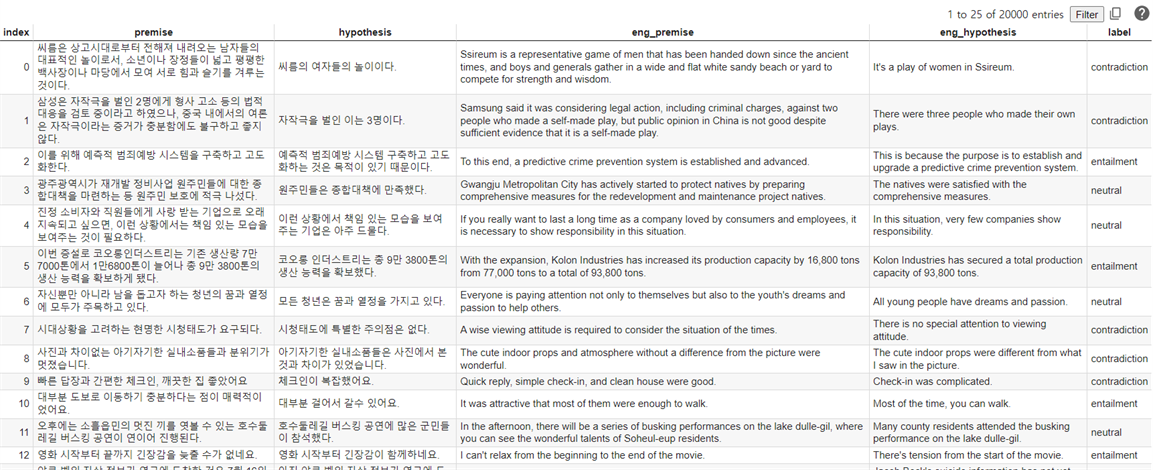

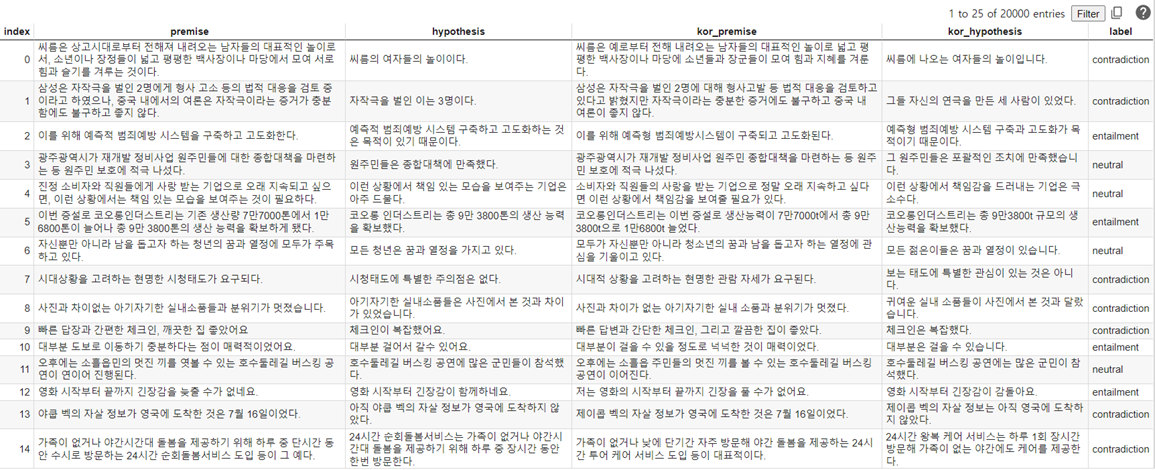

### train 원본에 번역 데이터 추가 : `train_total2` for model2
- data augmentation으로 2배 가량 증가

In [ ]:
train_premise = "/content/drive/MyDrive/Colab Notebooks/nli/premise_translate_final.csv"
train_hypothesis = "/content/drive/MyDrive/Colab Notebooks/nli/hypothesis_translate_final.csv"
test_path = "/content/drive/MyDrive/Colab Notebooks/nli/data/test_data.csv"
sub_path = "/content/drive/MyDrive/Colab Notebooks/nli/data/sample_submission.csv"

train_premise2 = "/content/drive/MyDrive/Colab Notebooks/nli/train2_premise_final.csv"
train_hypothesis2 = "/content/drive/MyDrive/Colab Notebooks/nli/train2_hypothesis_final.csv"

In [ ]:
t_p = pd.read_csv(train_premise)
t_h = pd.read_csv(train_hypothesis)
train_df2 = pd.concat([t_p['kor_premise'],t_h[['kor_hypothesis', 'label']]], axis = 1)
train_df2.columns = ['premise', 'hypothesis', 'label']

In [ ]:
t_p2 = pd.read_csv(train_premise2)
t_h2 = pd.read_csv(train_hypothesis2)
train_additional2 = pd.concat([t_p2['kor_premise'],t_h2[['kor_hypothesis', 'label']]], axis = 1)
train_additional2.columns = ['premise', 'hypothesis', 'label']

In [ ]:
train_translate = pd.concat([train_df2,train_additional2])
train_total2 = pd.concat([train_total, train_translate])

### train 학습 데이터를 번역 데이터로 변경 : `train_total3` for model3 

In [ ]:
train_total3 = pd.concat([train_df2, train_additional])

# **3. 토크나이징 및 모델 학습**

In [ ]:
def convert_examples_to_features(sent_list1, sent_list2, max_seq_len, tokenizer):

    input_ids, attention_masks, token_type_ids = [], [], []

    for sent1, sent2 in tqdm(zip(sent_list1, sent_list2), total=len(sent_list1)):
        encoding_result = tokenizer.encode_plus(sent1, sent2, max_length=max_seq_len, pad_to_max_length=True)

        input_ids.append(encoding_result['input_ids'])
        attention_masks.append(encoding_result['attention_mask'])
        token_type_ids.append(encoding_result['token_type_ids'])

    input_ids = np.array(input_ids, dtype=int)
    attention_masks = np.array(attention_masks, dtype=int)
    token_type_ids = np.array(token_type_ids, dtype=int)

    return (input_ids, attention_masks, token_type_ids)

In [ ]:
class NLIClassifier(Model):
    def __init__(self, model_name):
        super(NLIClassifier, self).__init__()
        self.bert = TFAutoModel.from_pretrained(model_name, num_labels=3, from_pt=True)
        self.dropout = tf.keras.layers.Dropout(rate=0.5)
        self.classifier = Dense(3, kernel_initializer=TruncatedNormal(0.02),activation='softmax') #가중치 초기화, 활성화함수

    def call(self, inputs, attention_mask=None, token_type_ids=None, training=False):
        input_ids, attention_mask, token_type_ids=inputs
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        pooled_output = outputs[1]
        pooled_output = self.dropout(pooled_output, training=training)
        prediction = self.classifier(pooled_output)

        return prediction

In [ ]:
def fold_training(train, test_df, model_name):
  cv = StratifiedKFold(n_splits = 5, random_state = 2022,shuffle=True)
  cv_pred = []
    
  for idx, (train_idx, val_idx) in enumerate(cv.split(train[["premise","hypothesis"]], pd.DataFrame(train['label']))):
    X_train, X_val = train[["premise","hypothesis"]].iloc[train_idx],  train[["premise","hypothesis"]].iloc[val_idx]
    y_train, y_val = pd.DataFrame(train['label']).iloc[train_idx], pd.DataFrame(train['label']).iloc[val_idx]

    train_fold = pd.concat([X_train, y_train], axis = 1)
    valid_fold = pd.concat([X_val, y_val], axis = 1)

    train_fold['premise'] = train_fold['premise'].str.replace('[^ㄱ-ㅎㅏ-ㅣ가-힣 0-9]', '')
    train_fold['hypothesis'] = train_fold['hypothesis'].str.replace('[^ㄱ-ㅎㅏ-ㅣ가-힣 0-9]', '')
    valid_fold['premise'] = valid_fold['premise'].str.replace('[^ㄱ-ㅎㅏ-ㅣ가-힣 0-9]', '')
    valid_fold['hypothesis'] = valid_fold['hypothesis'].str.replace('[^ㄱ-ㅎㅏ-ㅣ가-힣 0-9]', '')

    tokenizer = AutoTokenizer.from_pretrained(model_name)
    max_seq_len = 128

    X_train = convert_examples_to_features(train_fold['premise'], train_fold['hypothesis'],  max_seq_len=max_seq_len, tokenizer=tokenizer)
    X_valid = convert_examples_to_features(valid_fold['premise'], valid_fold['hypothesis'], max_seq_len=max_seq_len, tokenizer=tokenizer)
    X_test = convert_examples_to_features(test_df['premise'], test_df['hypothesis'],max_seq_len=max_seq_len, tokenizer=tokenizer)

    train_label = train_fold['label'].tolist()
    val_label = valid_fold['label'].tolist()
    test_label = test_df['label'].tolist()
    idx_encode = LabelEncoder()
    idx_encode.fit(train_label)

    y_train = idx_encode.transform(train_label) # 주어진 고유한 정수로 변환
    y_val = idx_encode.transform(val_label) # 고유한 정수로 변환

    label_idx = dict(zip(list(idx_encode.classes_), idx_encode.transform(list(idx_encode.classes_))))
    idx_label = {value: key for key, value in label_idx.items()}

    model = NLIClassifier(model_name)

    optimizer = AdamWeightDecay(1e-5, weight_decay_rate=1e-4)  #과적합 방지
    loss = tf.keras.losses.SparseCategoricalCrossentropy()
    metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
    model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

    early_stopping = EarlyStopping(
        monitor="val_accuracy", 
        min_delta=0.001,
        mode = 'max',
        patience=2)
    
    model.fit(
        X_train, y_train, epochs=3, batch_size = 8, validation_data=(X_valid, y_val),
        callbacks = [early_stopping])
    
    pred = model.predict(X_test)
    pred_df = pd.DataFrame(pred)
    cv_pred.append(pred_df)
    print('fold{} training finished!'.format(idx+1))

  return cv_pred


In [ ]:
def training(train, test_df, model_name):
  train, valid = train_test_split(train, test_size=0.2, shuffle=True, stratify=train['label'], random_state = 2022)

  train['premise'] = train['premise'].str.replace('[^ㄱ-ㅎㅏ-ㅣ가-힣 0-9]', '')
  train['hypothesis'] = train['hypothesis'].str.replace('[^ㄱ-ㅎㅏ-ㅣ가-힣 0-9]', '')
  valid['premise'] = valid['premise'].str.replace('[^ㄱ-ㅎㅏ-ㅣ가-힣 0-9]', '')
  valid['hypothesis'] = valid['hypothesis'].str.replace('[^ㄱ-ㅎㅏ-ㅣ가-힣 0-9]', '')

  tokenizer = AutoTokenizer.from_pretrained(model_name)
  max_seq_len = 128

  X_train = convert_examples_to_features(train['premise'], train['hypothesis'],  max_seq_len=max_seq_len, tokenizer=tokenizer)
  X_valid = convert_examples_to_features(valid['premise'], valid['hypothesis'], max_seq_len=max_seq_len, tokenizer=tokenizer)
  X_test = convert_examples_to_features(test_df['premise'], test_df['hypothesis'],max_seq_len=max_seq_len, tokenizer=tokenizer)

  train_label = train['label'].tolist()
  val_label = valid['label'].tolist()
  test_label = test_df['label'].tolist()
  idx_encode = LabelEncoder()
  idx_encode.fit(train_label)

  y_train = idx_encode.transform(train_label) # 주어진 고유한 정수로 변환
  y_val = idx_encode.transform(val_label) # 고유한 정수로 변환

  label_idx = dict(zip(list(idx_encode.classes_), idx_encode.transform(list(idx_encode.classes_))))
  idx_label = {value: key for key, value in label_idx.items()}

  model = NLIClassifier(model_name)

  optimizer = AdamWeightDecay(1e-5, weight_decay_rate=1e-4)  #과적합 방지
  loss = tf.keras.losses.SparseCategoricalCrossentropy()
  metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
  model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

  early_stopping = EarlyStopping(
      monitor="val_accuracy", 
      min_delta=0.001,
      mode = 'max',
      patience=2)
    
  model.fit(
      X_train, y_train, epochs=3, batch_size = 8, validation_data=(X_valid, y_val),
      callbacks = [early_stopping])
    
  pred = model.predict(X_test)
  pred_df = pd.DataFrame(pred)
  return pred_df


In [ ]:
test_df['premise'] = test_df['premise'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 0-9]", "")
test_df['hypothesis'] = test_df['hypothesis'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 0-9]", "")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  


## 3-1. MODEL 1 : train 원본 + dev 추가 데이터로 학습 (RoBERTa-Large)  
(실제 학습에서는 각 모델의 학습을 따로따로 진행하고 확률값과 모델 weight를 저장하였습니다.) 

In [ ]:
fold_pred_list = fold_training(train_total, test_df, model_name = 'klue/roberta-large')

## 3-2. MODEL 2 :  번역 데이터를 추가한 데이터로 학습 (RoBERTa-Large)  
(실제 학습에서는 각 모델의 학습을 따로따로 진행하고 확률값과 모델 weight를 저장하였습니다.) 

In [ ]:
fold_pred_list2 = fold_training(train_total2, test_df, model_name = 'klue/roberta-large')

## 3-3. MODEL 3 :  기본 train 데이터를 번역 데이터로 변경 (RoBERTa-Large, 데이터 증강x)  
(실제 학습에서는 각 모델의 학습을 따로따로 진행하고 확률값과 모델 weight를 저장하였습니다.) 

In [ ]:
pred_df1 = training(train_total3, test_df, model_name = 'klue/roberta-large')

## 3-4. MODEL 4 : 해석 데이터를 추가하지 않은 원본 데이터로 학습 (Pytorch, KoELECTRA)  
(실제 학습에서는 각 모델의 학습을 따로따로 진행하고 확률값과 모델 weight를 저장하였습니다.) 

In [ ]:
MODEL_NAME = 'monologg/koelectra-base-v3-discriminator'
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
config = AutoConfig.from_pretrained(MODEL_NAME)
config.num_labels = 3

model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, config=config)

train_dataset, eval_dataset = train_test_split(train_total, test_size=0.2, shuffle=True, stratify=train_total['label'], random_state = 2022)

tokenized_train = tokenizer(
    list(train_dataset['premise']),
    list(train_dataset['hypothesis']),
    return_tensors="pt",
    max_length=128, # Max_Length = 190
    padding=True,
    truncation=True,
    add_special_tokens=True
)

tokenized_eval = tokenizer(
    list(eval_dataset['premise']),
    list(eval_dataset['hypothesis']),
    return_tensors="pt",
    max_length=128,
    padding=True,
    truncation=True,
    add_special_tokens=True
)

tokenized_test = tokenizer(
    list(test_df['premise']),
    list(test_df['hypothesis']),
    return_tensors="pt",
    max_length=128,
    padding=True,
    truncation=True,
    add_special_tokens=True
)

In [ ]:
class BERTDataset(torch.utils.data.Dataset):
    def __init__(self, pair_dataset, label):
        self.pair_dataset = pair_dataset
        self.label = label

    def __getitem__(self, idx):
        item = {key: val[idx].clone().detach() for key, val in self.pair_dataset.items()}
        item['label'] = torch.tensor(self.label[idx])
        
        return item

    def __len__(self):
        return len(self.label)

In [ ]:
def label_to_num(label):
    label_dict = {"contradiction": 0, "entailment": 1, "neutral": 2, "answer": 3}
    num_label = []

    for v in label:
        num_label.append(label_dict[v])
    
    return num_label
train_label = label_to_num(train_dataset['label'].values)
eval_label = label_to_num(eval_dataset['label'].values)
test_label = label_to_num(test_df['label'].values)

train_dataset = BERTDataset(tokenized_train, train_label)
eval_dataset = BERTDataset(tokenized_eval, eval_label)
test_dataset = BERTDataset(tokenized_test, test_label)

In [ ]:
def compute_metrics(pred):
  """ validation을 위한 metrics function """
  labels = pred.label_ids
  preds = pred.predictions.argmax(-1)
  probs = pred.predictions

  # calculate accuracy using sklearn's function
  acc = accuracy_score(labels, preds) # 리더보드 평가에는 포함되지 않습니다.

  return {
      'accuracy': acc,
  }

In [ ]:
# 모델 초모수 수정하기
training_ars = TrainingArguments(
    output_dir='./result',
    num_train_epochs=7,
    per_device_train_batch_size=32, # 64
    learning_rate=5e-5,
    weight_decay=0.1,
    save_total_limit=5,
    save_steps=500,
    evaluation_strategy='steps',
    eval_steps = 500,
    load_best_model_at_end = True,
)

trainer = Trainer(
    model=model,
    args=training_ars,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

trainer.train()

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

Tokenizer_NAME = "monologg/koelectra-base-v3-discriminator"
tokenizer = AutoTokenizer.from_pretrained(Tokenizer_NAME)

MODEL_NAME = './result/checkpoint-4500'
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME)
model.resize_token_embeddings(tokenizer.vocab_size)
model.to(device)

In [ ]:
dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)

model.eval()
output_pred = []
output_prob = []

for i, data in enumerate(tqdm(dataloader)):
    with torch.no_grad():
        outputs = model(
            input_ids=data['input_ids'].to(device),
            attention_mask=data['attention_mask'].to(device),
            token_type_ids=data['token_type_ids'].to(device)
        )
    logits = outputs[0]
    prob = F.softmax(logits, dim=-1).detach().cpu().numpy()
    logits = logits.detach().cpu().numpy()
    result = np.argmax(logits, axis=-1)

    output_pred.append(result)
    output_prob.append(prob)
  
pred_answer, output_prob = np.concatenate(output_pred).tolist(), np.concatenate(output_prob, axis=0).tolist()
pred_df2 = pd.DataFrame(output_prob)

100%|██████████| 105/105 [00:04<00:00, 21.96it/s]


# **4. 앙상블 및 최종 제출**

In [ ]:
train1_fold4 = fold_pred_list[3]
train1_fold5 = fold_pred_list[4]
train2_fold2 = fold_pred_list2[1]
train2_fold3 = fold_pred_list2[2]
train2_fold4 = fold_pred_list2[3]
train2_fold5 = fold_pred_list2[4]
train3 = pred_df1
train4 = pred_df2

pred_ensemble = (train1_fold4 + train1_fold5 + train2_fold2 + train2_fold3 + train2_fold4 + train2_fold5 + train3 + train4)/8

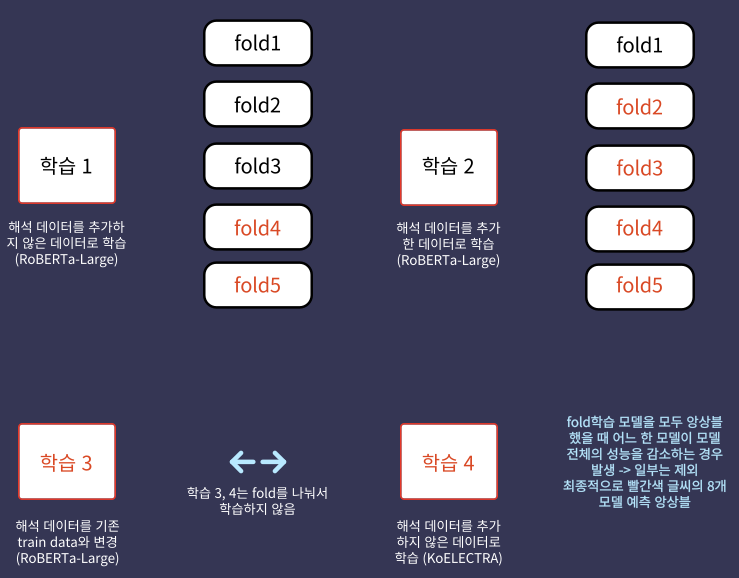

In [ ]:
label_idx = {'contradiction':0, 'entailment':1, 'neutral':2}
result = [np.argmax(val) for val in np.array(pred_ensemble)]
out = [list(label_idx.keys())[_] for _ in result]

In [ ]:
sub_path = "/content/drive/MyDrive/Colab Notebooks/nli/data/sample_submission.csv"
submission = pd.read_csv(sub_path)

In [ ]:
submission['label']=out
submission.to_csv("/content/drive/MyDrive/Colab Notebooks/nli/fold/pred/지후.csv", index=False)